<a href="https://colab.research.google.com/github/rubeshajith/NETFLIX-MOVIES-AND-TV-SHOWS-CLUSTERING/blob/main/NETFLIX_MOVIES_AND_TV_SHOWS_CLUSTERING.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Problem Statement**

This dataset consists of tv shows and movies available on Netflix as of 2019. The dataset is collected from Flixable which is a third-party Netflix search engine.

In 2018, they released an interesting report which shows that the number of TV shows on Netflix has nearly tripled since 2010. The streaming service’s number of movies has decreased by more than 2,000 titles since 2010, while its number of TV shows has nearly tripled. It will be interesting to explore what all other insights can be obtained from the same dataset.

Integrating this dataset with other external datasets such as IMDB ratings, rotten tomatoes can also provide many interesting findings.

## <b>In this  project, you are required to do </b>
1. Exploratory Data Analysis 

2. Understanding what type content is available in different countries

3. Is Netflix has increasingly focusing on TV rather than movies in recent years.
4. Clustering similar content by matching text-based features



# **Attribute Information**

1. show_id : Unique ID for every Movie / Tv Show

2. type : Identifier - A Movie or TV Show

3. title : Title of the Movie / Tv Show

4. director : Director of the Movie

5. cast : Actors involved in the movie / show

6. country : Country where the movie / show was produced

7. date_added : Date it was added on Netflix

8. release_year : Actual Releaseyear of the movie / show

9. rating : TV Rating of the movie / show

10. duration : Total Duration - in minutes or number of seasons

11. listed_in : Genere

12. description: The Summary description

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [84]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
import warnings 
warnings.filterwarnings('ignore')

In [85]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [ ]:
# df = pd.read_csv("/content/drive/MyDrive/data/project/NETFLIX MOVIES AND TV SHOWS CLUSTERING.csv")

In [ ]:
# Path of IMDB files
# basic_df = pd.read_csv("/content/drive/MyDrive/data/project/title_data.tsv",sep='\t')
# rating_df = pd.read_csv("/content/drive/MyDrive/data/project/rating_data.tsv",sep='\t')

In [ ]:
# basic_df['titleType'] = basic_df['titleType'].str.lower()
# basic_df['titleType'] = basic_df['titleType'].str.replace('tvepisode', 'tv show')
# basic_df['titleType'] = basic_df['titleType'].str.replace('tvseries', 'tv show')
# basic_df['titleType'] = basic_df['titleType'].str.replace('tvmovie', 'movie')


In [ ]:
# imdb_df= pd.merge(basic_df.set_index('tconst'), rating_df.set_index('tconst'), left_index=True, right_index=True)

In [ ]:
#lower case titles
# df['title']= df['title'].str.lower()
# df['type']= df['type'].str.lower()


# imdb_df['primaryTitle'] = imdb_df['primaryTitle'].str.lower()
# imdb_df['originalTitle'] = imdb_df['originalTitle'].str.lower()


In [ ]:
# imdb_df = imdb_df[imdb_df.startYear.apply(lambda x: str(x).isnumeric())]
# imdb_df['startYear'] = imdb_df['startYear'].astype(int)


In [ ]:
# tv_show_df = df[df["type"]== "tv show"]
# tv_show_df.shape
# (2410, 12)

(2410, 12)

In [ ]:
# movie_df = df[df["type"]== "movie"]
# movie_df.shape
# (5377, 12)

(5377, 12)

In [ ]:
# tv_final_df = pd.merge(tv_show_df, imdb_df, left_on=['title',"type"], right_on=['primaryTitle',"titleType"],how="left")
# tv_final_df.shape
# (5894, 22)

In [ ]:
# movie_final_df = pd.merge(movie_df, imdb_df, left_on=['title','release_year'], right_on=['primaryTitle','startYear'],how="left")
# movie_final_df.shape
# (6056, 22)

In [ ]:
# final_frame = pd.concat([tv_final_df,movie_final_df])
# final_frame.shape
# (11950, 22)

(11950, 22)

In [ ]:
# final_frame['numVotes'] = final_frame['numVotes'].fillna(0)

In [ ]:
# final_frame = final_frame.groupby('title',as_index=False).apply(lambda x:x.loc[x.numVotes.idxmax()])
# final_frame.shape
# (7787, 22)

In [ ]:
# final_frame.to_csv(r"/content/drive/MyDrive/data/project/netflix_imdb.csv", index=False)

In [86]:
df = pd.read_csv("/content/drive/MyDrive/data/project/netflix_imdb.csv")


In [87]:
df.head(5)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
0,s28,movie,#alive,Cho Il,"Yoo Ah-in, Park Shin-hye",South Korea,"September 8, 2020",2020,TV-MA,99 min,"Horror Movies, International Movies, Thrillers","As a grisly virus rampages a city, a lone man ...",movie,#alive,#saraitda,0.0,2020.0,\N,98,"Action,Drama,Horror",6.3,38671.0
1,s29,movie,#annefrank - parallel stories,"Sabina Fedeli, Anna Migotto","Helen Mirren, Gengher Gatti",Italy,"July 1, 2020",2019,TV-14,95 min,"Documentaries, International Movies","Through her diary, Anne Frank's story is retol...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,s30,tv show,#blackaf,NaN,"Kenya Barris, Rashida Jones, Iman Benson, Genn...",United States,"April 17, 2020",2020,TV-MA,1 Season,TV Comedies,Kenya Barris and his family navigate relations...,tv show,#blackaf,#blackaf,0.0,2020.0,2020,36,Comedy,6.6,4850.0
3,s31,movie,#cats_the_mewvie,Michael Margolis,NaN,Canada,"February 5, 2020",2020,TV-14,90 min,"Documentaries, International Movies",This pawesome documentary explores how our fel...,movie,#cats_the_mewvie,#cats_the_mewvie,0.0,2020.0,\N,90,Documentary,5.3,468.0
4,s32,movie,#friendbutmarried,Rako Prijanto,"Adipati Dolken, Vanesha Prescilla, Rendi Jhon,...",Indonesia,"May 21, 2020",2018,TV-G,102 min,"Dramas, International Movies, Romantic Movies","Pining for his high school crush for years, a ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [88]:
df['indexNumber'] = df["show_id"].replace("s","",regex=True).astype(int)
df.sort_values(['indexNumber'], ascending = [True], inplace = True)
df = df.reset_index()
df.drop(['indexNumber',"index"], 1, inplace = True)


Keeping just the imdb average rating lets drop all other columns from imdb dataset part

In [89]:
df.columns

Index(['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added',
       'release_year', 'rating', 'duration', 'listed_in', 'description',
       'titleType', 'primaryTitle', 'originalTitle', 'isAdult', 'startYear',
       'endYear', 'runtimeMinutes', 'genres', 'averageRating', 'numVotes'],
      dtype='object')

In [90]:
df = df.drop(["titleType","primaryTitle","originalTitle","isAdult","startYear","endYear","runtimeMinutes","genres","numVotes"],axis=1)

In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7787 entries, 0 to 7786
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   show_id        7787 non-null   object 
 1   type           7787 non-null   object 
 2   title          7787 non-null   object 
 3   director       5398 non-null   object 
 4   cast           7069 non-null   object 
 5   country        7280 non-null   object 
 6   date_added     7777 non-null   object 
 7   release_year   7787 non-null   int64  
 8   rating         7780 non-null   object 
 9   duration       7787 non-null   object 
 10  listed_in      7787 non-null   object 
 11  description    7787 non-null   object 
 12  averageRating  5994 non-null   float64
dtypes: float64(1), int64(1), object(11)
memory usage: 791.0+ KB


In [92]:
nan_percentile = {"columns_with_nan":[],"nan_percentile":[]}
for i in df.columns:
  nan_perc = df[i].isna().sum() / len(df) * 100
  if nan_perc > 0:
    nan_percentile["columns_with_nan"].append(i)
    nan_percentile["nan_percentile"].append(round(nan_perc,2))



In [93]:
nan_per = pd.DataFrame(nan_percentile)
nan_per

,columns_with_nan,nan_percentile
0,director,30.68
1,cast,9.22
2,country,6.51
3,date_added,0.13
4,rating,0.09
5,averageRating,23.03


Text(0.5, 0, 'Nan percentile')

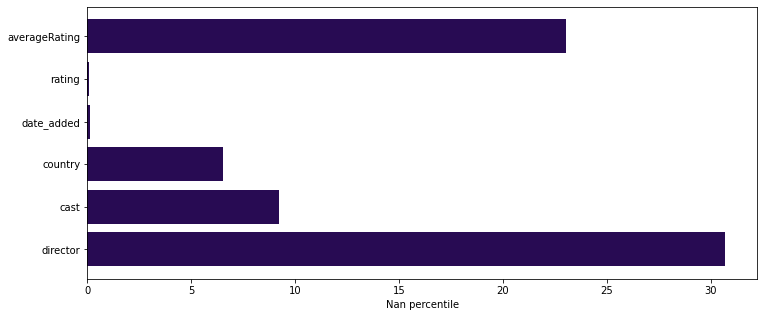

In [94]:
#Visualizing missing percentile
plt.figure(figsize=(12,5))
sns.set_palette("inferno")
plt.barh(nan_per["columns_with_nan"], nan_per["nan_percentile"])
plt.xlabel("Nan percentile")

<Figure size 1080x432 with 0 Axes>

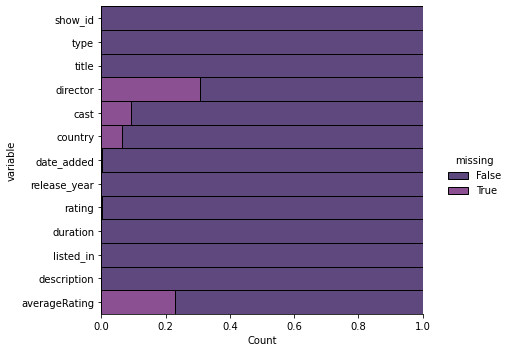

In [95]:
#Visualizing missing and non missing values in our dataframe

plt.figure(figsize=(15,6))
sns.displot(data=df.isna().melt(value_name="missing"), y="variable",hue="missing",multiple="fill", aspect=1.25)

### Handling NULL values

In [96]:
df[df["country"].isna()]

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,averageRating
16,s17,tv show,feb-09,NaN,"Shahd El Yaseen, Shaila Sabt, Hala, Hanadi Al-...",NaN,"March 20, 2019",2018,TV-14,1 Season,"International TV Shows, TV Dramas","As a psychology professor faces Alzheimer's, h...",NaN
38,s39,tv show,แผนร้ายนายเจ้าเล่ห์,NaN,"Chutavuth Pattarakampol, Sheranut Yusananda, N...",NaN,"March 30, 2019",2016,TV-14,1 Season,"International TV Shows, Romantic TV Shows, TV ...","When two brothers fall for two sisters, they q...",NaN
67,s68,movie,13th: a conversation with oprah winfrey & ava ...,NaN,"Oprah Winfrey, Ava DuVernay",NaN,"January 26, 2017",2017,NaN,37 min,Movies,Oprah Winfrey sits down with director Ava DuVe...,7.0
97,s98,movie,3 deewarein,Nagesh Kukunoor,"Naseeruddin Shah, Jackie Shroff, Juhi Chawla, ...",NaN,"December 31, 2019",2003,TV-MA,121 min,"Dramas, International Movies, Thrillers",A reporter interviews three convicts on death ...,7.8
117,s118,movie,5 cowok jagoan,Anggy Umbara,"Ario Bayu, Arifin Putra, Dwi Sasono, Muhadkly ...",NaN,"January 5, 2019",2017,TV-MA,106 min,"Action & Adventure, Comedies, International Mo...",Yanto asks his friends to help save a girlfrie...,NaN
141,s142,tv show,7seeds,NaN,"Nao Toyama, Jun Fukuyama, Katsuyuki Konishi, Y...",NaN,"March 26, 2020",2020,TV-MA,2 Seasons,"Anime Series, International TV Shows",Shy Natsu awakens as part of a group chosen to...,6.3
178,s179,movie,a go! go! cory carson halloween,"Alex Woo, Stanley Moore","Alan C. Lim, Smith Foreman, Maisie Benson, Ann...",NaN,"October 2, 2020",2020,TV-Y,22 min,Children & Family Movies,"Cory, Chrissy and Freddie are on the hunt for ...",6.4
179,s180,movie,a go! go! cory carson summer camp,"Stanley Moore, Alex Woo","Alan C. Lim, Smith Foreman, Abigail Vibat, Pfi...",NaN,"August 4, 2020",2020,TV-Y,21 min,Children & Family Movies,Cory's spending the summer at Camp Friendship ...,NaN
204,s205,movie,a mission in an old movie,Ahmad El-Badri,"Edward, Fifi Abdo, Lotfy Labib, Madeleine Mata...",NaN,"April 25, 2019",2012,TV-MA,98 min,"Comedies, International Movies",A young man struggles with his overbearing mot...,NaN
242,s243,movie,a trash truck christmas,Eddie Rosas,"Henry Keane, Glen Keane, Lucas Neff, Brian Bau...",NaN,"December 11, 2020",2020,TV-Y,28 min,Children & Family Movies,When Santa crash-lands in the junkyard on Chri...,5.5


After going through titles and cast names in our df of country NaN value, i figured out few rows which contained indian movies and tv shows, so lets assign those rows with our country name. Below are the rows which were inspected to be Indian movies or tv_shows

In [97]:
indian_mov_rows = [509,525,548,657,658,659,661,662,889,1124,1318,1319,1320,1321,3444,3445,3446,3447,3449,3450,3451,3454,3470,3668,3669,3670,3671,3672,3673,3674,
4043,4341,4441,4594,4595,4839,5035,5036,5049,5395,5396,5402,6040]

In [98]:
for index_num in indian_mov_rows:
  df.loc[index_num,"country"] = "India"

In [103]:
df['country'] = df['country'].fillna(df['country'].mode()[0])
df['cast'] = df['cast'].fillna("No Data")
df['director'] = df['director'].fillna("No Data")
df['averageRating'] = df['averageRating'].fillna(0)

In [104]:
df[df["rating"].isna()]

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,averageRating


Since ther are only 7 rows so lets just browse the rating from internet and replace them

In [105]:
rating_replacements = {67:"TV-PG",2359:"TV-14",3660:"TV-MA",3736:"TV-MA",3737:"NR",3738:"TV-MA",4323:"TV-MA"}
for index, rate in rating_replacements.items():
  df.loc[index, "rating"] = rate

In [106]:
df.isna().sum()

show_id           0
type              0
title             0
director          0
cast              0
country           0
date_added       10
release_year      0
rating            0
duration          0
listed_in         0
description       0
averageRating     0
dtype: int64

Since its hard to find date_added through internet, lets just drop them (10rows)

In [107]:
df = df[~df["date_added"].isna()]

In [108]:
df.shape

(7777, 13)

### Feature Manipulation

In [109]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7777 entries, 0 to 7786
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   show_id        7777 non-null   object 
 1   type           7777 non-null   object 
 2   title          7777 non-null   object 
 3   director       7777 non-null   object 
 4   cast           7777 non-null   object 
 5   country        7777 non-null   object 
 6   date_added     7777 non-null   object 
 7   release_year   7777 non-null   int64  
 8   rating         7777 non-null   object 
 9   duration       7777 non-null   object 
 10  listed_in      7777 non-null   object 
 11  description    7777 non-null   object 
 12  averageRating  7777 non-null   float64
dtypes: float64(1), int64(1), object(11)
memory usage: 850.6+ KB


Let's Generate new columns based on variables

Year and month

In [110]:
df["date_added"] = pd.to_datetime(df['date_added'])
df["month"] = df["date_added"].dt.month_name()
df["year_added"] = df["date_added"].dt.year

Age Targets based on rating

In [114]:
ratings_ages = {'TV-PG': 'Older Kids', 'TV-MA': 'Adults','TV-Y7-FV': 'Older Kids','TV-Y7': 'Older Kids','TV-14': 'Teens','R': 'Adults',
  'TV-Y': 'Kids','NR': 'Adults','PG-13': 'Teens','TV-G': 'Kids','PG': 'Older Kids','G': 'Kids','UR': 'Adults','NC-17': 'Adults'}
df['target_ages'] = df['rating'].replace(ratings_ages)
df['target_ages'].unique()

array(['Adults', 'Teens', 'Older Kids', 'Kids'], dtype=object)

### Top Countries with more contribution in netflix

In [111]:
filtered_countries = df["country"].str.split(", ")
filtered_countries = filtered_countries.explode("country")

In [112]:
filtered_countries.value_counts()[0:10].to_frame(name= "Counts")

,Counts
United States,3753
India,1033
United Kingdom,721
Canada,412
France,349
Japan,286
Spain,215
South Korea,212
Germany,199
Mexico,154


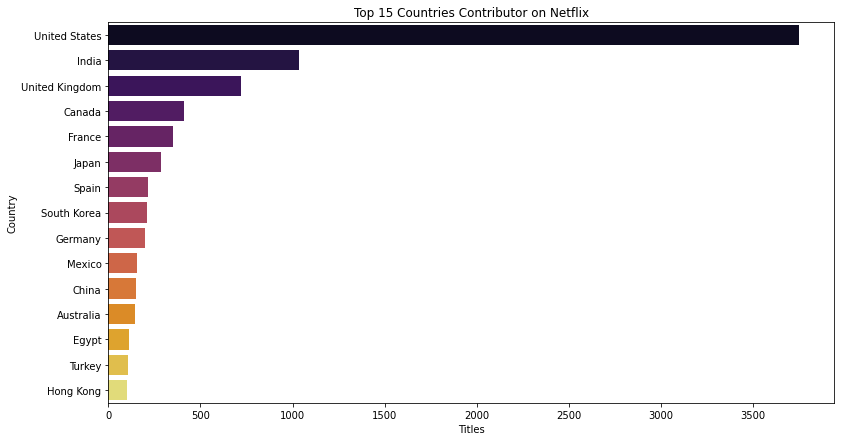

In [132]:
plt.figure(figsize=(13,7))
g = sns.countplot(y = filtered_countries, order=filtered_countries.value_counts().index[:15], palette='inferno')
plt.title('Top 15 Countries Contributor on Netflix')
plt.xlabel('Titles')
plt.ylabel('Country')
plt.show()

In [115]:
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,averageRating,month,year_added,target_ages
0,s1,tv show,3%,No Data,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,2020-08-14,2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...,7.3,August,2020,Adults
1,s2,movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,2016-12-23,2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...,5.8,December,2016,Adults
2,s3,movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,2018-12-20,2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow...",4.5,December,2018,Adults
3,s4,movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,2017-11-16,2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi...",7.0,November,2017,Teens
4,s5,movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,2020-01-01,2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...,6.8,January,2020,Teens


In [131]:
filtered_directors = df[df["director"] != "No Data"]
filtered_directors = filtered_directors["director"].str.split(", ")
filtered_directors = filtered_directors.explode("director")
filtered_directors.value_counts()[:10]

Jan Suter              21
Raúl Campos            19
Marcus Raboy           16
Jay Karas              15
Cathy Garcia-Molina    13
Jay Chapman            12
Youssef Chahine        12
Martin Scorsese        12
Steven Spielberg       10
Shannon Hartman         9
Name: director, dtype: int64

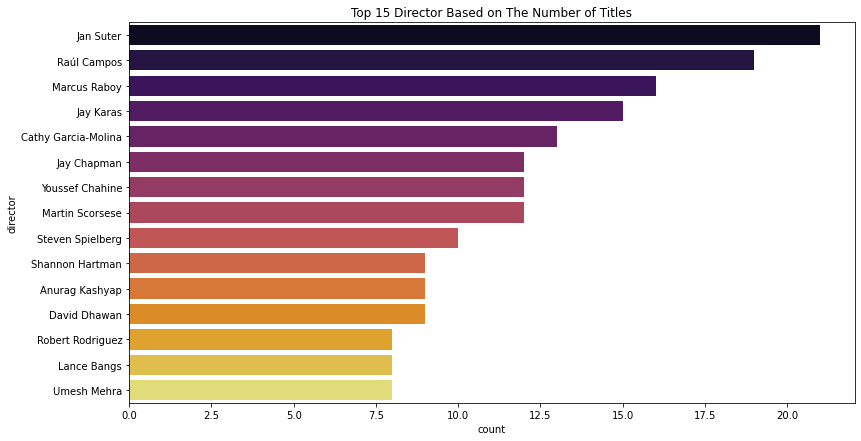

In [127]:
plt.figure(figsize=(13,7))
plt.title('Top 15 Director Based on The Number of Titles')
sns.countplot(y = filtered_directors, order=filtered_directors.value_counts().index[:15], palette='inferno')
plt.show()

In [133]:
tv_show_df = df[df["type"]=="tv show"]
movie_df = df[df["type"]=="movie"]

In [134]:
filtered_tvshow_directors = tv_show_df[tv_show_df["director"] != "No Data"]
filtered_tvshow_directors = filtered_tvshow_directors["director"].str.split(", ")
filtered_tvshow_directors = filtered_tvshow_directors.explode("director")

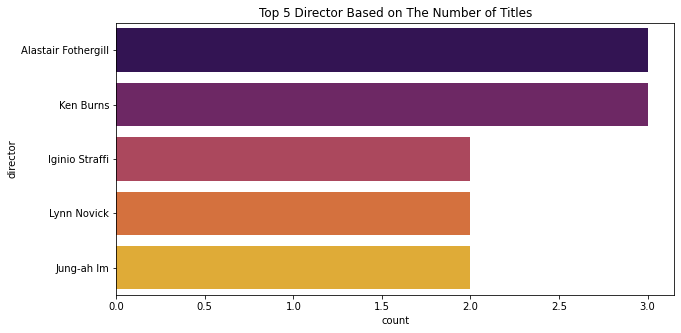

In [138]:
plt.figure(figsize=(10,5))
plt.title('Top 5 Director Based on The Number of Titles')
sns.countplot(y = filtered_tvshow_directors, order=filtered_tvshow_directors.value_counts().index[:5], palette='inferno')
plt.show()

In [223]:
filtered_movie_directors = movie_df[movie_df["director"] != "No Data"]
filtered_movie_directors = filtered_movie_directors["director"].str.split(", ")
filtered_movie_directors = filtered_movie_directors.explode("director")

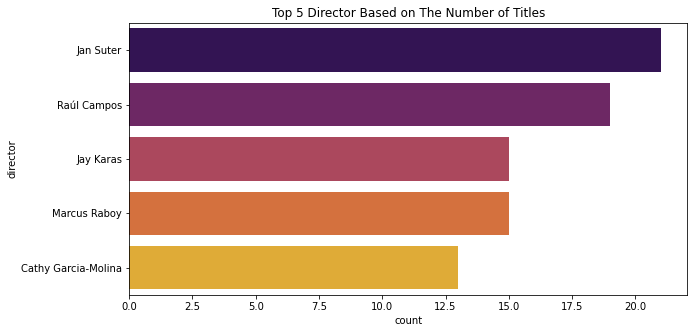

In [224]:
plt.figure(figsize=(10,5))
plt.title('Top 5 Director Based on The Number of Titles')
sns.countplot(y = filtered_movie_directors, order=filtered_movie_directors.value_counts().index[:5], palette='inferno')
plt.show()

In [237]:
tv_show_df["null_value"] = tv_show_df["director"].apply(lambda x: 1 if x== "No Data" else 0)
tv_show_df["null_value"].value_counts()

1    2216
0     184
Name: null_value, dtype: int64

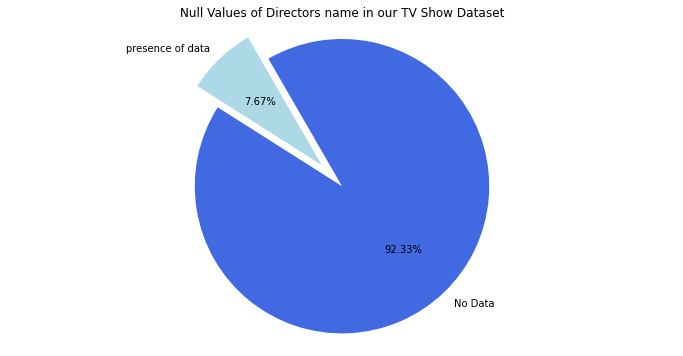

In [236]:
plt.figure(figsize=(12, 6))
labels=['presence of data', 'No Data']
plt.pie(tv_show_df["null_value"].value_counts().sort_values(),labels=labels,explode=[0.1,0.1],
        autopct='%1.2f%%',colors=['lightblue','royalblue'], startangle=120)
plt.title('Null Values of Directors name in our TV Show Dataset')
plt.axis('equal')
plt.show()

In [239]:
movie_df["null_value"] = movie_df["director"].apply(lambda x: 1 if x== "No Data" else 0)
movie_df["null_value"].value_counts()

0    5214
1     163
Name: null_value, dtype: int64

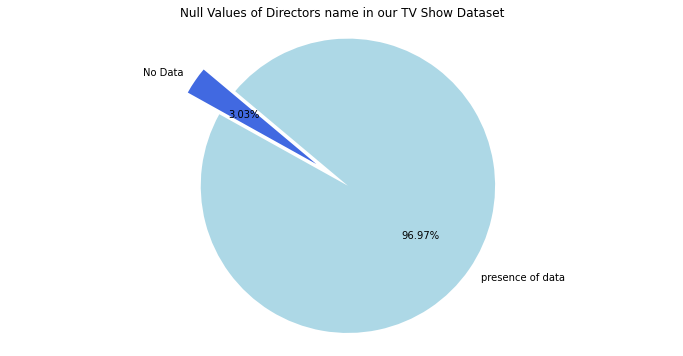

In [246]:
plt.figure(figsize=(12, 6))
labels=['No Data','presence of data']
plt.pie(movie_df["null_value"].value_counts().sort_values(),labels=labels,explode=[0.13,0.13],
        autopct='%1.2f%%',colors=['royalblue','lightblue'], startangle=140)
plt.title('Null Values of Directors Name in movie Dataset')
plt.axis('equal')
plt.show()

In [ ]:
movie_directors = movie_df[(movie_df["director"] != "No Data") & (movie_df["averageRating"]>= 8)]
movie_directors["director"] = movie_directors["director"].str.split(", ")
movie_director = movie_directors.explode("director")
movie_director.head(5)


In [222]:
movie_dir_top_rate = movie_director.groupby("director")["averageRating"].max().sort_values(ascending=False)
movie_dir_top_rate[:10].to_frame()

,averageRating
director,
Antongiulio Panizzi,9.2
Harald Zwart,9.1
Steven Spielberg,9.0
Tilak Shetty,9.0
Peter Jackson,9.0
Robert O. Peters,9.0
Jayaprakash Radhakrishnan,9.0
Samir Al Asfory,9.0
Quentin Tarantino,8.9


In [186]:
movie_director['director'].value_counts()[:5]

Quentin Tarantino       5
Martin Scorsese         5
Steven Spielberg        4
Christopher Storer      3
Hrishikesh Mukherjee    2
Name: director, dtype: int64

In [207]:
top_directors = movie_director[["director","title","averageRating"]]
qt_df = top_directors[top_directors["director"]== "Quentin Tarantino"]
qt_df.sort_values("averageRating", ascending=False).reset_index(drop=True)


,director,title,averageRating
0,Quentin Tarantino,pulp fiction,8.9
1,Quentin Tarantino,django unchained,8.4
2,Quentin Tarantino,inglourious basterds,8.3
3,Quentin Tarantino,kill bill: vol. 1,8.2
4,Quentin Tarantino,kill bill: vol. 2,8.0


In [208]:
ms_df = top_directors[top_directors["director"]== "Martin Scorsese"]
ms_df.sort_values("averageRating", ascending=False).reset_index(drop=True)

,director,title,averageRating
0,Martin Scorsese,goodfellas,8.7
1,Martin Scorsese,the departed,8.5
2,Martin Scorsese,no direction home: bob dylan,8.4
3,Martin Scorsese,raging bull,8.2
4,Martin Scorsese,taxi driver,8.2


In [209]:
ss_df = top_directors[top_directors["director"]== "Steven Spielberg"]
ss_df.sort_values("averageRating", ascending=False).reset_index(drop=True)

,director,title,averageRating
0,Steven Spielberg,schindler's list,9.0
1,Steven Spielberg,indiana jones and the raiders of the lost ark,8.4
2,Steven Spielberg,indiana jones and the last crusade,8.2
3,Steven Spielberg,catch me if you can,8.1
